---
# Student Info & Imports

Student info: Nadav Kahlon, ID: 213438575

In [ ]:
# import necessary packages
import torch
import torchvision
import pandas as pd
import math
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections.abc import Iterable
from torch.utils.data import Dataset, DataLoader

# set manual seed for PyTorch (for reproducible results)
torch.manual_seed(0)

# mount Google Drive and move to the assignment's directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/2ndAssignmentDL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/2ndAssignmentDL


---
# Question 1 - SplitLinear layers
In this question we implement and analyze a network layer called SplitLinear. The layer splits the input features into equally-sized groups, feeds them through the same linear-ReLU layer, and finally concatenate the results to produce the output.

In the next question we combine this layer in a deep architecture trained on the Fashion-MNIST dataset.

##Part A: Code

In the following cell you can find the definition of the SplitLinear class, which represents this layer.

A few notes regarding the implementation:

* Each splitted chunk of features in the input to the forward propagation procedure goes through the linear-ReLU layer independently of the others, so in order to make the process **more efficient in parallel-computation environments** I decided to concatentate those chunks along the **batch** dimension, and feed the resulting tensor as a whole to the linear-ReLU layer - so only one feed-through occurs. Then, by splitting the output tensor to chunks along the batch dimension and concatenating them along the features dimension, we get the required output.

* I decided to expand the task we were given, and implement the layer in such a way that it may split the input into **any number of chunks** specified by the user. The reason for that is that I wanted to try and incorporate parameter-sharing in a larger scale, so I could "get my hands dirty" in building such a model - even if it is a very basic one :)

As a sanity check for this layer, I decided to combine it in the networks we train in the *next question* on the Fashion-MNIST.

In [ ]:
'''
A neural-network layer that splits the features in its input into equally-sized
  chunks, feeds the chunks through the same linear-ReLU layer, and concatenates
  the results to produce its output.
Input samples should be flattened, i.e. input is of shape (batch_size, in_features).
'''
class SplitLinear(nn.Module):
    '''
    Constructor: creates a SplitLinear layer.
    Input:
      > 'in_features' - number of features of input samples.
      > 'out_features' - number of features of output samples.
      > 'split_to' - the number of equal chunks the layer splits its input to.
        Default: 2
      > 'bias' - If set to False, the layer will not learn an additive bias.
        Default: True
    In order for the layer to function properly, both 'in_features' and 'out_features'
      should be a multiplication of 'split_to' (so the layer can split the input
      to equally-sized chunks). If this condition is not met, the constructor
      throws an assertion error.
    '''
    def __init__(self, in_features, out_features, split_to=2, bias=True):
        # call Module class constructor to initialize the layer
        super().__init__()

        # make sure input/output dimensions are valid
        assert in_features % split_to == 0 and out_features % split_to == 0, ('' +
               f'in_features ({in_features}) and out_features ({out_features}) of ' +
               f'a SplitLinear layer should be a multiplication of the split_to ' + 
               f'({split_to}).')
        
        # number of features in input and output samples
        self.in_features = in_features
        self.out_features = out_features
        # number of features in splitted chunks of the input and output samples
        self.in_chunk_size = int(in_features/split_to)
        self.out_chunk_size = int(out_features/split_to)

        # create linear layer to feed the splitted input data through and initialzie
        # weights as described in the following cell
        self.linear = nn.Linear(in_features=self.in_chunk_size,
                                out_features=self.out_chunk_size,
                                bias=bias)
        weight_bound = (6 / (self.in_chunk_size + self.out_chunk_size)) ** 0.5
        nn.init.uniform_(self.linear.weight, -weight_bound, weight_bound)

    '''
    Forward propagation through a SplitLinear layer, as described above.
    Input: tensor of shape (batch_size, self.in_features).
    Output: tensor of shape (batch_size, self.out_features).
    Makes sure the input is of a valid shape, if it's not - throws an assertion
      error.
    '''
    def forward(self, input):
        # validate input's shape
        assert len(input.shape) == 2 and input.shape[1] == self.in_features, ('' +
                f'SplitLinear layer expected input of shape (?, {self.in_features}) ' +
                f'but got input of shape {tuple(input.shape)}.')
        batch_size = input.shape[0]

        # split data to chunks over the features dimension
        in_chunks = torch.split(input, self.in_chunk_size, dim=1)
        # stack the chunks along the batch dimension
        in_stacked_chunkes = torch.cat(in_chunks, dim=0)
        # feed the chunks together through the same linear-relu layer 
        out_stacked_chunks = F.relu(self.linear(in_stacked_chunkes)) 
        # split the output along the batch dimension to obtain output chunks
        out_chunks = torch.split(out_stacked_chunks, batch_size, dim=0) 
        # and concatenate them along the feature dimension to obtain output
        output = torch.cat(out_chunks, dim=1)

        return output

##Part B: Considerations for Weights Initializations

I decided to initialize the weights using *Xavier initialization*: randomly sampled from the following uniform distribution $U(-\sqrt{\frac{6}{n_{in}'+n_{out}'}}, \sqrt{\frac{6}{n_{in}'+n_{out}'}})$
where $n_{in}'$ and $n_{out}'$ are the numbers of features in the input and the output of the linear-ReLU layer that is incorporated to the SplitLinear layer, respectively. I explain the motivation for this choice in the following paragraphs.

First, we use random sampling to "break the symmetry": to avoid cases such as one in which weights going into two different neurons are initialized with the same value - resulting in these 2 neurons having the same activations during forward propagation and the weights having the same gradiants during backward propagation. Gradiant based learning methods will update those weights in the same way (since their gradiants are the same). As a result these two neurons will forever have the same weights going into them, and will forever act the same - reducing the expressive power of the network and wasting time and memory to manipulate both neurons. By initializing the weights randomly, it is very unlikely to run into such cases.

Second, this specific distribution is picked to avoid "vanishing" or "exploding" gradiants - cases in which gradiants in the network are exponentially large or exponentially small. It happens due to extreme activations later in the network during forward propagation (which leads to extreme cost gradiants), or due to extreme gradiants earlier in the network during backpropagation. The reason for that is the fact that forward and backward propagations through some types of layers (such as the linear layer featured in a SplitLinear layer) multiply vectors (activations and gradiants) by the weight matrices. By multiplying a lot of these (through a lot of layers) we can get exponentially large or exponentially small activations and/or gradiants, which can break gradiant-based learning methods (by diverging if the gradiants are too large, or moving too slowly if the gradiants are too small).

It is shown [here](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#sec-numerical-stability) that if, through a linear layer with no bias, activations are IID with 0 mean and weights are IID with 0 mean (and activations and weights are ID), the variance of the weights should be the inverse of the number of features in the input to the layer - so the output activations will have the same variance as the input activations.

Now, let's take take a look at our SplitLinear special layer. If the **input features** are IID with 0 mean - every **chunk of input features** are IID with that exact distribution. Using the above-mentioned method ensures that **all chunks of output features** after the linear layer have the same variance and mean as of the input, and therefore the distribution of **all the output features** also have variance and mean as of the input! So all we need to do to avoid extremely large or extremely small activations is to make sure the weights have mean 0 and variance which is the inverse of the number of features in each input chunk.

The same argument works for gradiants, with the number of features in each output chunk instead. Xavier's method offers a compromise between the two - setting the variance of the weights to the inverse of their average: $\frac{2}{n_{in}'+n_{out}'}$.
The above mentioned uniform distribution has this property, and therefore we use it.

P.S: we haven't really learned about bias initialization, so I didn't know what to do there. Therefore, I decided to let the default initialization of torch.nn.Linear to decide on these.. Hope that's OK ^_^

##Part C: Block Diagram of the SplitLinear layer

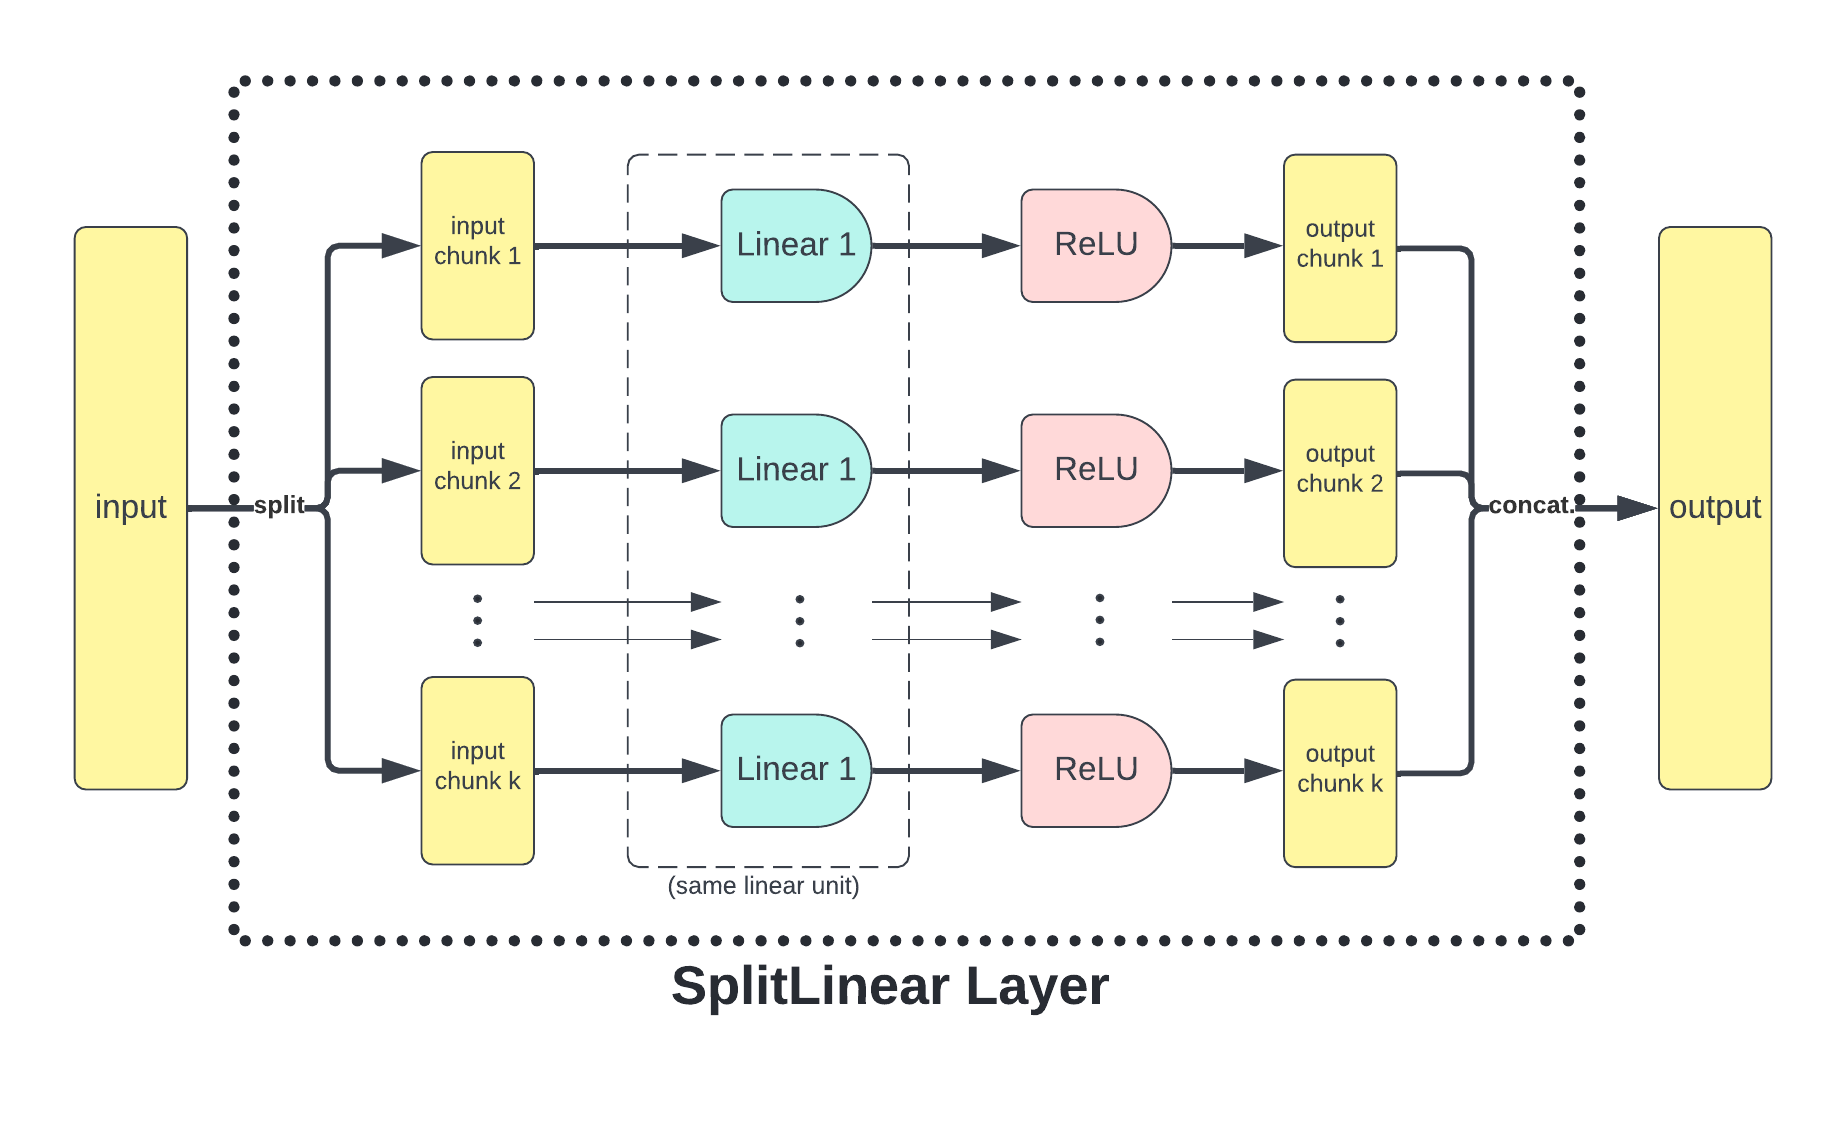

## Parts D-F: Theoretical Analyzis


In these 3 parts we will analyze the theoretical properties of the layer.We will use the following notations:
* $n_{in}$ = number of features in the input of the layer.
* $n_{out}$ = number of features in the output of the layer.
* $k$ = number of chunks we split the input to.
* $n_{in}'$ = number of features in each input chunk. Since the input's $n_{in}$ features are splitted to $k$ chunks, this is the same as $\frac{n_{in}}{k}$.
* $n_{out}'$ = number of features in each output chunk. Since the output's $n_{out}$ features are a concatenation of the $k$ output chunks, this is the same as $\frac{n_{out}}{k}$.

###Part D

In a neural network, each linear connection between a layer with $m_{in}$ neurons and a layer with $m_{out}$ neurons requires a weight parameter between each neuron in the input layer to each neuron in the output layer - a total of $m_{in}m_{out}$ weights, plus a bias for each neuron in the output layer - a total of $m_{out}$ biases. In total: $m_{in}m_{out}+m_{out}$ tuneable parameters.

The only tuneable parameters we store as part of the SplitLinear layer are the parameters of the linear unit that produces each output chunk, given each input chunk. This is a linear connection between $n_{in}'$ neurons to $n_{out}'$ neurons, so a total of $n_{in}'n_{out}'+n_{out}'=\frac{n_{in}}{k}\frac{n_{out}}{k}+\frac{n_{out}}{k}=\frac{n_{in}n_{out}}{k^2}+\frac{n_{out}}{k}$ parameters are requires. On the other hand, an ordinary linear connection which have the same input-output dimensions - $n_{in},n_{out}$, will need $n_{in}n_{out}+n_{out}$ tuneable parameters.

As long as $k>1$, the SplitLinear layer requires far less parameters.The ratio between the number of parameters used by a normal linear connection and the number of parameters used by a SplitLinear connection is $\frac{n_{in}n_{out}+n_{out}}{\frac{n_{in}n_{out}}{k^2}+\frac{n_{out}}{k}}=\frac{n_{in}+1}{n_{in}+k}\,k^2$. For a large number of input features, this ratio approaches $k^2$.

For instance, if $n_{in}=128,\,n_{out}=256,\,k=2$, a normal linear connection will require $33024$ parameters, while a SplitLinear connection will require much less - only $8320$ parameters. This is an improvement by a factor of $3.9692$.

###Part E

For this part we will assume that $k=2$ (so this part will not ruin the next part). We will use the following notations:

$x$ = a single input sample to the SplitLinear layer; a vector of $n_{in}$ features.

$x_0,x_1$ = the 2 halfs of the input vector which are fed to the linear unit: $x_0=[x]_{1,...,\frac{n_{in}}{2}},\,x_1=[x]_{\frac{n_{in}}{2}+1,...,n_{in}}$

$W$ = the weight matrix of the linear unit.

$b$ = the bias vector of the linear unit.

$z_0,\,z_1$ = the output of the linear unit for both halfs of the input vector: $z_0=Wx_0+b,\, z_1=Wx_1+b$.

$y_0,\,y_1$ = the output of the ReLU activation for both halfs of the input: $y_0=ReLU(z_0),\,y_1=ReLU(z_1)$. Those are the 2 halfs of the output of the SplitLinear layer.

$y$ = the output of the LinearSplit layer: $y=[y_0\,\,y_1]^T$.

$C$ = the cost function.
$\newcommand{\gradc}[1]{\frac{\partial C}{\partial #1}}$
$\newcommand{\grad}[2]{\frac{\partial #1}{\partial #2}}$

We will assume that we are given the gradiant of the cost with respect to the output of the LinearSplit layer - $\frac{\partial y}{\partial C}$. Using this we can simply get the gradiant of the cost with respect to $y$'s halfs - $y_0$ and $y_1$:

$\gradc{y_0}=[\gradc{y}]_{1,...,\frac{n_{out}}{2}}$

$\gradc{y_1}=[\gradc{y}]_{\frac{n_{out}}{2}+1,...,n_{out}}$

Let's calculate the gradiant of the cost function with respect to a weight $w_{ij},\,1 \leq i \leq \frac{n_{out}}{2},\,1 \leq j \leq \frac{n_{in}}{2}$.

First, for $l=0,1$, the following holds:

$\grad{[y_l]_i}{w_{ij}} = \grad{[y_l]_i}{[z_l]_i}\grad{[z_l]_i}{w_{ij}} = 
\grad{ReLU([z_l]_i)}{[z_l]_i}\grad{(\sum^{n_{in}/2}_{t=1}w_{it}[x_l]_t\,+b_i)}{w_{ij}}=1\{[z_l]_i \geq 0\}\cdot[x_l]_j=1\{[z_l]_i \geq 0\}\cdot[x]_{{\frac{n_{in}}{2}}l+j}$

Because $w_{ij}$ affects $y_0$ and $y_1$ only through their $i$'th element, we can conclude:

$\gradc{w_{ij}} =
\grad{C(y)}{w_{ij}} =
\grad{C(y_0, y_1)}{w_{ij}} =
\grad{C([y_0]_i, [y_1]_i)}{w_{ij}} =
\grad{C}{[y_0]_i}\grad{[y_0]_i}{w_{ij}}+\grad{C}{[y_1]_i}\grad{[y_1]_i}{w_{ij}} =
[\grad{C}{y}]_i [x]_j 1\{[z_0]_i \geq 0\} + [\gradc{y}]_{\frac{n_{out}}{2}+i}[x]_{\frac{n_{in}}{2}+j}1\{[z_1]_i\geq0\} =
\sum_{l=0}^{1}([\gradc{y}]_{\frac{n_{out}}{2}l+i}[x]_{\frac{n_{in}}{2}l+j}1\{[z_l]_i\geq0\}) =
\sum_{l=0}^{1}([\gradc{y}]_{\frac{n_{out}}{2}l+i}[x]_{\frac{n_{in}}{2}l+j}1\{[Wx_l+b]_i\geq0\}) =
\sum_{l=0}^{1}([\gradc{y}]_{\frac{n_{out}}{2}l+i}[x]_{\frac{n_{in}}{2}l+j}1\{[W[x]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\}) $

In a similiar fashion we can obtain:

$\gradc{b_i}=\sum_{l=0}^{1}([\gradc{y}]_{\frac{n_{out}}{2}l+i}1\{[W[x]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\})$

Those formulas are with respect to a single sample $x$. To get the gradiants with respect to a batch of $N$ samples $\{(X_n,Y_n)\}_{n=1}^N$, we simply need to sum those gradiants over all the samples - since each parameter affects the cost through every output sample:

$\gradc{w_{ij}} =
\sum_{n=1}^{N}
\sum_{l=0}^{1}([\gradc{Y_n}]_{\frac{n_{out}}{2}l+i}[X_n]_{\frac{n_{in}}{2}l+j}1\{[W[X_n]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\}) $

$\gradc{b_i} =
\sum_{n=1}^{N}
\sum_{l=0}^{1}([\gradc{Y_N}]_{\frac{n_{out}}{2}l+i}1\{[W[X_n]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\})$

###Part F

In the previous part we saw that if we split the input into $k=2$ equally-sized chunks of features, feed them through the same linear-ReLU unit with weight $W$ and bias $b$, the gradiant of the cost function for a batch $\{(X_n,Y_n)\}_{n=1}^N$ of samples with respect to the parameters of the layers is:
$\newcommand{\gradc}[1]{\frac{\partial C}{\partial #1}}$
$\newcommand{\grad}[2]{\frac{\partial #1}{\partial #2}}$

$\gradc{w_{ij}} =
\sum_{n=1}^{N}
\sum_{l=0}^{1}([\gradc{Y_N}]_{\frac{n_{out}}{2}l+i}[X_n]_{\frac{n_{in}}{2}l+j}1\{[W[X_n]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\}) $

$\gradc{b_i} =
\sum_{n=1}^{N}
\sum_{l=0}^{1}([\gradc{Y_N}]_{\frac{n_{out}}{2}l+i}1\{[W[X_n]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\})$

For each $1 \leq i \leq \frac{n_{out}}{2},\,1 \leq j \leq \frac{n_{in}}{2}$.

By looking at those formulas, we can see that the gradiants are a sum of 2 expressions, each corresponds to the affect of the parameters on a single chunk of features. For instance, the gradiant of the cost for a single sample $(x,y)$ with respect to $w_{ij}$ is the sum of the following expression for $l=0,1$:

$[\gradc{y}]_{\frac{n_{out}}{2}l+i}[x]_{\frac{n_{in}}{2}l+j}1\{[W[x]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\}$

Where $[\gradc{y}]_{\frac{n_{out}}{2}l+i}$ is the affect of the $(l+1)$'th chunk of output features on the cost, and $[x]_{\frac{n_{in}}{2}l+j}1\{[W[x]_{\frac{n_{in}}{2}l+1,...,\frac{n_{in}}{2}(l+1)}+b]_i\geq0\}$ is the affect of the weight on that output chunk.

Let's try to generalize this idea: if we would split the input into $k$ chunks instead of just $2$, we will have k chunks of output features that the ouput $y$ will be composed of. Each, will affect the cost through the corresponding components of the gradiant of the cost with respect to $y$: $[\gradc{y}]_{\frac{n_{out}}{k}l+1,...,\frac{n_{out}}{k}(l+1)}$ (for $l=0,...,k-1$). Every such chunk of output features will depend on the weights and biases of the linear-ReLU unit through the corresponding input chunks ($[x]_{\frac{n_{in}}{k}l+1,...,\frac{n_{in}}{k}(l+1)}$ for $l=0,...k-1$) in a similiar "linear-ReLU fashion".

We can therefore infer that the corresponding gradiants of the cost for a batch $\{(X_n,Y_n)\}_{n=1}^N$ of $N$ exapmles will now be:

$\gradc{w_{ij}} =
\sum_{n=1}^{N}
\sum_{l=0}^{k-1}([\gradc{Y_n}]_{\frac{n_{out}}{k}l+i}[X_n]_{\frac{n_{in}}{k}l+j}1\{[W[X_n]_{\frac{n_{in}}{k}l+1,...,\frac{n_{in}}{k}(l+1)}+b]_i\geq0\}) $

$\gradc{b_i} =
\sum_{n=1}^{N}
\sum_{l=0}^{k-1}([\gradc{Y_n}]_{\frac{n_{out}}{k}l+i}1\{[W[X_n]_{\frac{n_{in}}{k}l+1,...,\frac{n_{in}}{k}(l+1)}+b]_i\geq0\})$

For each $1 \leq i \leq \frac{n_{out}}{k},\,1 \leq j \leq \frac{n_{in}}{k}$.

For instance, if we would split the input into $k=4$ chunks, we will have:

$\gradc{w_{ij}} =
\sum_{n=1}^{N}
\sum_{l=0}^{3}([\gradc{Y_n}]_{\frac{n_{out}}{4}l+i}[X_n]_{\frac{n_{in}}{4}l+j}1\{[W[X_n]_{\frac{n_{in}}{4}l+1,...,\frac{n_{in}}{4}(l+1)}+b]_i\geq0\}) $

$\gradc{b_i} = 
\sum_{n=1}^{N}
\sum_{l=0}^{3}([\gradc{Y_n}]_{\frac{n_{out}}{4}l+i}1\{[W[X_n]_{\frac{n_{in}}{4}l+1,...,\frac{n_{in}}{4}(l+1)}+b]_i\geq0\})$

For each $1 \leq i \leq \frac{n_{out}}{4},\,1 \leq j \leq \frac{n_{in}}{4}$.

---
# Question 2 - DropNorm layers
In this question we implement and analyze a neural network layer called DropNorm which is a concatenation of a special dropout layer and a special normalization layer.

We use it to train a deep classification network on the Fashion-MNIST dataset using a GPU, and compare the results to those obtained by using PyTorch's implementation of the corresponding layers.

##Part A: Specifications and Code

The DropNorm layer works in the following manner:

* At train time, the layer randomly chooses certain features to drop (the same features for all samples in a batch) with a constant probability (a hyperparameter). Then, it normalizes the features that are left according to their mean and variance (for each sample individually). Finally, it scales and shifts the features according to learned parameters (associated with each feature individually).

* At test time the layer normalizes the features of the input samples according to their mean and variance (for each sample individually). Then, it scales and shifts the features using the above-mentioned learned parameters (associated with each feature individually).

In the following cell you can find the definition of the DropNorm class, which represents this layer.

In [ ]:
'''
A neural-network layer that works in the following manner:
  > At train time, the layer randomly chooses certain features to drop (the same
    features for all samples in a batch) with a constant probability (a hyperparameter).
    Then, it normalizes the features that are left according to their mean and
    variance (for each sample individually). Finally, it scales and shifts the features
    according to learned parameters (associated with each feature individually).
  > At test time the layer normalizes the features of the input samples according
    to their mean and variance (for each sample individually). Then, it scales and
    shifts the features using the above-mentioned learned parameters (associated
    with each feature individually).
Samples can be of any shape, i.e. input is of any shape of the form
  (batch_size, in_dim_1, ..., in_dim_d).
'''
class DropNorm(nn.Module):
    '''
    Constructor: creates a DropNorm layer.
    Input:
      > 'in_shape' - shape of input samples (without batch dimension).
      > 'drop_rate' - the probability for the dropout part of the layer to drop
        a neuron. Should be a number exclusively between 0 and 1 otherwise an, 
        assertion error is thrown. Default: 0.5.
      > 'eps' - small real number to add to the denominator while normalizing
        features by their variance. Defaule: 1e-5.
    '''
    def __init__(self, in_shape, drop_rate=0.5, eps=1e-5):
        # call Module class constructor to initialize the layer
        super().__init__()

        # make sure drop_rate is valid and store it
        assert 0 < drop_rate < 1, ("DropNorm: drop_rate should be exclusively" +
               "between 0 and 1.")
        self.drop_rate = drop_rate
        
        # initialize scale parmeter and shift parameter of the batch-norm part
        # to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(in_shape))
        self.beta = nn.Parameter(torch.zeros(in_shape))

        # store additional values
        self.eps = eps
        self.in_shape = in_shape if isinstance(in_shape, Iterable) else [in_shape]
        # (note the special treatment for a 1-dimensional input shape)

    '''
    Forward propagation through a DropNorm layer, as described above.
    Input: tensor representing a batch samples of the specified shape (self.in_shape),
      where the first dimension is the batch dimension.
    Output: tensor of the same shape as the input.
    '''
    def forward(self, X):
        # get device on which the layer runs
        device = self.gamma.device

        # generate mask of kept features (all features are kept during test time)
        mask  = (torch.rand(self.in_shape) > self.drop_rate if self.training
                 else torch.full(size=self.in_shape, fill_value=True)).to(device)

        # calculate mean and variance of kept features (per sample)
        kept_feats = X[:, mask]
        means = torch.mean(kept_feats, dim=1) # shape (batch_size,)
        vars = torch.var(kept_feats, dim=1) # shape (batch_size,)

        # normalize each sample's features according to the mean and variance of its
        # *kept* features
        X_moved = torch.movedim(X, 0, -1)
        X_hat_moved = (X_moved - means) / torch.sqrt(vars + self.eps)
        X_hat = torch.movedim(X_hat_moved, -1, 0)
        
        # scale and shift features according to learned parameters
        Y = self.gamma * X_hat + self.beta

        # in train time - apply the dropping of output features, and rescale them 
        # so their mean is not changed
        if self.training:
            Y = Y * mask / (1-self.drop_rate)
        
        return Y

A few notes regarding the implementation:

* I decided to make the drop rate a hyperparameter (and not a constant 0.5), since that expansion is pretty straight-forward and makes the code look cleaner.
* Unlike the implementation of dropout in the learning guide (and similiar to the implementation presented in D2L [here](http://d2l.ai/chapter_multilayer-perceptrons/dropout.html#implementation-from-scratch)), I decided to rescale the remaining features only (those that were not dropped in train time) by a factor of 1/(1-drop_rate). As a result, the expected activation $x$ remains the same as without dropout:

  $E[Dropout(x)] = E_{x\space dropped?}[E[Dropout(x)\space|\space x\space dropped?]] = drop\_rate\cdot E[Dropout(x)\space|\space x\space dropped]+(1-drop\_rate)\cdot E[Dropout(x)\space|\space x\space wasn't\space dropped]=drop\_rate\cdot 0 + (1-drop\_rate)\cdot E[\frac{x}{1-drop\_rate}]=E[x]$

* If you take a closer look at my code, you may notice that the actual dropping of features does not take place until the very end of the forward procedure. I decided to do that so we won't need to specify the kept features when applying shifting and scaling, and so the code will be easier to read and understand correctly. Note - that doesn't mean that the means and variances are calculated with respect to all the features! We generate the mask of the kept features in the very beginning of the procedure, and use it to make sure means and variances are calculated on the kept features only. In the end, we use this mask to actually drop features (and rescale the remaining ones by 1/(1-drop_rate) so their expected value is not changed).

* Note that in order to apply the normalization for each sample individually, we first move the batch dimension to the end so it will correctly broadcast with the means tensor and variances tensor, both of shape (batch_size,). But don't worry - after normalizing, we move it back to the beginning.

##Part B: Considerations for Test Time Specifications

Abvoe, I described the way forward propagation happens through the DropNorm layer during test time. For convenience, I repeat the explanation again here:

> At test time the layer normalizes the features of the input samples according to their mean and variance (for each sample individually). Then, it scales and shifts the features using learned parameters (associated with each feature individually).

I decided on those actions for the following reasons:

* First, I needed to decide how the dropout part of the layer will act in test time. Dropping features randomly is a way of adding noise to the computation in-between the layers (to make the model more robust to noise). However, during test time we want to get the best predictions possible. It is not the time to make it harder for the model, and therefore it is not the time to add such noise. As a result, I decided to omit the dropout part during test time

* Second, I needed to decide what to do during the second step of the layer - the normalization step. Since normalization is done based on the mean and variance of the features of *each sample individually*, the rest of the network will learn to work with output from this layer which consists of *individually normalized samples*. Therefore, I decided to make the normalization step work the same in test time as well - normalizing each sample individually. This part is practically the first part of what's called 'layer normalization' - as described in "Layer Normalization" by J.L. Ba et al. (2016). There, the writers make this same decision.

* And lastly, I needed to decide what to do with the final part of the layer - the scaling and shifting by learned parameters associated with each feature individually. Since the layer specifically learned those parameters for its calculations later in the network, the most logical decision is to make the layer work the same here as well - scaling and shifting each feature by the corresponding learned parameters.

##Part C: Considerations for Parameter Initializations

The only (learned, not hyper) parameters of this layer are gamma and beta - the tensors holding the scaling and shifting values used on each feature individually in the final part of the layer, after normalizing the mean and variance pf each sample's features.

In absence of any information regarding the distribution of features the rest of the network may wish to work with, we need to initialize both gamma and beta in the constructor. The reasonable approach is to initially not change the features at all, taking into account the fact that each sample's features were previously normalized. Therefore - I decided to initialize each scaling parameter in gamma to 1, and each shifting parameter in beta to 0.

##Parts D-F: Comparing Performances On Fashion-MNIST 

Next, we train 2 deep classification networks - both with a similiar structure. The only difference is that one of the networks consists of our DropNorm layer, and the other consists of a combination of PyTorch's built-in dropout and normalization layers. Training and testing is performed using a GPU (if available).

We compare the performances of both trained networks on the test set, and draw conclusions regarding the uniqueness of the DropNorm layer.

In [ ]:
''' Get available device, preferably GPU '''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cuda:0


In [ ]:
''' Load data '''

# load Fashion-MNIST dataset
trans=torchvision.transforms.Compose(
    [torchvision.transforms.PILToTensor(),
     torchvision.transforms.ConvertImageDtype(torch.float)])
train_data = torchvision.datasets.FashionMNIST(
    root="/FashionMNIST", train=True, download=True,
    transform=trans)
test_data = torchvision.datasets.FashionMNIST(
    root="/22961", train=False, download=True,
    transform=trans)

# create dataloader for train data and test data
train_dataloader = DataLoader(train_data, batch_size=512,
                              num_workers=1,shuffle=True,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

In [ ]:
''' Some constant values we will use in the process: '''
epochs = 10 # number of epochs we will use to train each model
CE_loss = nn.NLLLoss() # the loss measure we use here - cross entorpy
lr = 0.1 # learning rate used for both models' optimizers
batches = len(train_dataloader) # number of train batches
drop_rate = 0.5 # drop rate used by both models to drop neurons

In [ ]:
'''
Creates a deep nn.Sequential classification model with a few occurrences of some
  type of layer.
Input:
  > 'get_layer' - a callable that accepts an input shape (of a sample, i.e. with
    no batch dimensiom) and returns an instance of an nn.Module. That nn.Module
    should accept input samples of the shape specified by the argument sent to
    'layer', and return output samples of that same shape.
  > 'device' - device to create the network on.
Output: a deep nn.Sequential model of a specific architecture, containing a few
  occurrences of layers generated using 'get_layer'. The layer accepts inputs
  of the shape of the samples in the Fashion-MNIST dataset, and outputs a vector
  of 10 probabilities.
'''
def create_model(get_layer, device):
    return nn.Sequential(
        get_layer((1,28,28)),
        nn.Flatten(),
        nn.Linear(784, 256), nn.ReLU(),
        get_layer((256)),
        SplitLinear(256, 128),
        nn.Linear(128, 10),
        nn.LogSoftmax(dim=1)).to(device)

In [ ]:
'''
Trains a given 10-class classification model for the Fashion-MNIST dataset for the
  above mentioned number of epochs (stored in 'epochs').
Input:
  > 'model' - an nn.Moudle to fit on the Fashion-MNIST dataset.
  > 'device' - device to work on.
Output: a pair (batch_loss, batch_acc) where:
  > 'batch_loss' is a list of the history of the losses of the model on the training
    batches during train time.
  > 'batch_acc' is a list of the history of the accuracies of the model on the 
    training batches during train time.
Documents the process in real time using the tqdm package.
'''
def train_model(model, device):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr) # optimizer for training
    batch_loss = [] # list to track losses history
    batch_acc = [] # list to track accuracies history

    for epoch in range(epochs):
        epoch_desc = f'epoch {epoch+1} / {epochs}' # string description of the epoch

        # process each training batch
        for (imgs, labels) in tqdm(train_dataloader, epoch_desc, position=0, leave=True):
            # trasfer batch to working device
            imgs = imgs.to(device)
            labels = labels.to(device)
            # run forward and backward passes on the batch
            optimizer.zero_grad()
            model.train()
            y_model = model(imgs)
            loss = CE_loss(y_model, labels)
            loss.backward()
            optimizer.step()
            # record performance on current batch
            predicted_labels = y_model.argmax(dim=1)
            acc = (predicted_labels == labels).sum()/len(labels)
            batch_loss.append(loss.item())
            batch_acc.append(acc.item())
        
    return batch_loss, batch_acc

In [ ]:
'''
Tests a given 10-class classification model on the test partition of the
Fashion-MNIST dataset.
Input:
  > 'model' - nn.Module representing the model to test.
  > 'device' - device to work on.
Output: a pair (test_loss, test_acc) of the loss and the accuracy of the model
  on the test partition (respectively)
'''
def test_model(model, device):
    with torch.no_grad():
        # load test data
        imgs, labels = next(iter(test_dataloader))
        imgs = imgs.to(device)
        labels = labels.to(device)
        # evaluate model on test data 
        model.eval()
        y_model = model(imgs)
        loss = CE_loss(y_model, labels)
        predicted_labels = y_model.argmax(dim=1)
        acc = (predicted_labels == labels).sum()/len(labels)
    return loss, acc

###Part D: Training a Network with PyTorch's Built-In Dropout & Normalization Layers

In this part we will need to create sequence structure that consists of a combination of PyTorch's built-in dropout and normalization layers, to replace our DropNorm layer.

Let's review the way the DropNorm layer works:
* First, it randomly drops features in a constant rate. The way to do it using built-in layers is by a Dropout layer (in package torch.nn).
* Next, it normalizes each sample's features according to their mean and variance and then rescales and shift each feature according to a pair of learned parameters associated with it. This is exactly what a layer-normalization process does, and we can use PyTorch's implementation of it - LayerNorm (in package torch.nn).

By creating a Sequential model that concatenates both of these layers together we can obtain a structure that we will use instead of DropNorm layers.

epoch 10 / 10: 100%|██████████| 118/118 [00:17<00:00,  6.73it/s]


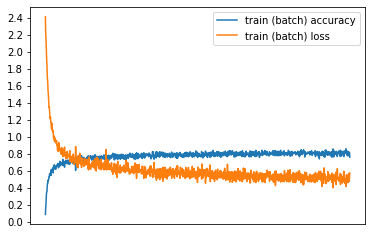

Results on test set:
 	loss = 0.5417680144309998
 	accuracy = 0.8230999708175659



In [ ]:
# for this part - we need to use the above mentioned sequence of PyTorch built-in
# layers as the replacement for the DropNorm layer; the following lambda expression
# generates such a sequence given the input (sample) shape
get_layer = lambda in_shape: nn.Sequential(nn.Dropout(p=drop_rate),
                                           nn.LayerNorm(in_shape))

# create and fit a model
model = create_model(get_layer, device)
batch_loss, batch_acc = train_model(model, device)

# plot loss and accuracy history for the train batches
plt.plot(batch_acc, label='train (batch) accuracy')
plt.plot(batch_loss, label='train (batch) loss')
plt.xticks([])
plt.yticks(torch.arange(0.0,2.5,0.2))
plt.legend()
plt.show()

test_loss, test_acc = test_model(model, device)
print(f'Results on test set:\n',
      f'\tloss = {test_loss}\n',
      f'\taccuracy = {test_acc}\n')

###Part E: Training a Network With DropNorm layers

epoch 10 / 10: 100%|██████████| 118/118 [00:18<00:00,  6.50it/s]


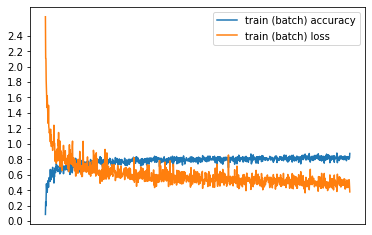

Results on test set:
 	loss = 0.4569340944290161
 	accuracy = 0.8342999815940857



In [ ]:
# for this part - we want the designated layer to be our DropNorm layer, so I set
# the get_layer parameter to a function that calls DropNorm's constructor
get_layer = lambda in_shape: DropNorm(in_shape=in_shape, drop_rate=drop_rate)

# create and fit a model
model = create_model(get_layer, device)
batch_loss, batch_acc = train_model(model, device)

# plot loss and accuracy history for the train batches
plt.plot(batch_acc, label='train (batch) accuracy')
plt.plot(batch_loss, label='train (batch) loss')
plt.xticks([])
plt.yticks(torch.arange(0.0,2.5,0.2))
plt.legend()
plt.show()

test_loss, test_acc = test_model(model, device)
print(f'Results on test set:\n',
      f'\tloss = {test_loss}\n',
      f'\taccuracy = {test_acc}\n')

###Part F: Comparison and Conclusions

Before we begin, in order to make the discussion cleaner - let us call the network with built-in PyTorch layers "network A", and the network with our DropNorm layer "network B".

In fact, both networks produced very similiar performance results, though network B was a bit better:
* The test loss of network B was around 0.4569, while the test loss of network A was around 0.5418.
* The test accuracy of network B was around 83.43%, while the test accuracy of network A was around 82.31%.

However if we take a look at the training-history curves, we can see that the training process of network B was a bit "noisier" (with sharper jumps up and down during the process) than that of network A.

Now, in order to decide which network we might want to use more, let's examine more closely the difference between a DropNorm layer and a sequence of a Dropout layer and a LayerNorm layer. Both do practically the same, except for one crucial differnce: DropNorm layer performs the layer-normalization process **on the remaining neurons only**, while the LayerNorm part of the above mentioned sequence of 2 layers is not aware of the dropped neurons (dropped by the Dropout layer that came before it) and treats them as standard neurons with activation 0. That means that **the dropped neurons (with value 0) take part in the normalization and rescaling & shifting process** - affecting the variance of the features of each sample (and therefore - affecting the normalization) and are affected by the shifting by the learned parameter beta.

Now the debatable question is - do we want our network to act like that? I think not. Zeroing neurons and still taking them into account can heavily affect the variance of the features (by increasing it). This, in turn, can produce unwelcomed behaviour - such as making the activations smaller by some factor each time (since we divide by the SD of the features as part of the normalization process). Forward propagating data through many of these layers can decrease the variance of the features exponentially, leading to vanishing gradiants. Moreover, now the dropped features will be shifted by the learned parameter beta, and will therefore have affect on later parts of the network (since their activations will no longer be 0). This is probably unwanted.

This emphasizes the uniqueness of the DropNorm layer - it is a concatenation of a dropout layer and a layer-normalization layer that is actually aware of the dropped neurons and makes sure to omit them from the normalization process. It is designated for this combo of actions!

To sum up, I would choose to use network B - the network with our DropNorm layers. Though the performances were pretty similiar in our case, I believe that according to the above-mentioned issues of the other option, DropNorm layer will work better in models of larger scale.

##Part G: Theoretical Anaysis of Backpropagation Through DropNorm Layers


Let's assume our input consists of N four-dimensional samples $\{X_n\}_{n=1}^N$ such that each $X_n$ is a vector of 4 (real) features: $X_n=(X_{n1},X_{n2},X_{n3},X_{n4})$. We will address features by their index (feature $1$ will be the first feature, feature $2$ will be the second feature, etc.). Let's also assume that the output of a DropNorm layer for input tensor $X=[X_{ni}]_{n=1,...,N;\space i=1,...,4}$ is a tensor $Y=[Y_{ni}]_{n=1,...,N;\space i=1,...,4}$, and that $Y$ is later used in some other parts of a network to calculate a loss function $C$. We will denote the parameters of that DropNorm layer with $\gamma=(\gamma_1,\gamma_2,\gamma_3,\gamma_4)$ and $\beta=(\beta_1,\beta_2,\beta_3,\beta_4)$. We will also assume that we are given with $\gradc{Y}$, and will calculate $\gradc{X}$.
$\newcommand{\gradc}[1]{\frac{\partial C}{\partial #1}}$
$\newcommand{\grad}[2]{\frac{\partial #1}{\partial #2}}$
$\newcommand{\gradc}[1]{\frac{\partial C}{\partial #1}}$
$\newcommand{\grad}[2]{\frac{\partial #1}{\partial #2}}$
$\newcommand{\split}[5]{
\begin{equation*} #1=\begin{cases} #2 & #3 \\ #4 & #5 \end{cases}
\end{equation*}}$
$\newcommand{\forinf}[3]{\split{#1}{#2}{i\in F}{#3}{i\notin F}}$

The first part of the DropNorm layer is to drop some features. Let's call the set of (indices of) the features that **were not dropped** $F\subseteq\{1,2,3,4\}$ (the dropped features are $\bar{F}$).

Each output sample $Y_n$ depends only on the $n$'th input sample (since normalization is done per-sample individually and then the rescaling and shifting does not mix features at all), so we can examine each sample individually. Let's say we have an output sample $y=(y_1,y_2,y_3,y_3)$ and that the corresponding input sample is $x=(x_1,x_2,x_3,x_4)$.

Let's denote the mean and variance of the features that were not dropped in sample x in:
$\mu_F(x)=mean(\{x_i\space|\space i\in F\})=\frac{1}{|F|}\sum_{i\in F}x_i$
$\newcommand{\muf}{\mu_F(x)}$

$\sigma_F^2(x)=var(\{x_i\space|\space i\in F\})=\frac{1}{|F|}\sum_{i\in F} (x_i-\mu_F(x))^2$
$\newcommand{\varf}{\sigma_F^2(x)}$

So we can obtain:

* $\forinf{\grad{\muf}{x_i}}{\frac{1}{|F|}}{0}$

* $\forinf{\grad{\varf}{x_i}}{\frac{2}{|F|}(x_i-\muf)}{0}$

> The first derivative is simple. The derivation of the second derivative can be found in [Note #1](https://drive.google.com/file/d/1d2bBF-SG2RGZzmgk57i86NP17sT2wCpM/view?usp=sharing).

We will also denote the normalized remaining features with:

$\hat{x_i}=\frac{x_i-\muf}{\sqrt{\varf+ϵ}},\space i\in F$

It can be shown that for any $i,j\in F,\space i\not=j$ the following holds:

* $\grad{\hat{x_i}}{x_i} = \frac{1-\frac{1}{|F|}(\hat{x_i}^2+1)}{\sqrt{\varf+\epsilon}}$

* $\grad{\hat{x_i}}{x_j} = \frac{-\frac{1}{|F|}(\hat{x_i}\hat{x_j}+1)}{\sqrt{\varf+\epsilon}}$

> The derivation of the first derivative can be found in [Note #2](https://drive.google.com/file/d/1-RkCEkX3I_7-c5DPzD4rpFnleLnm-pHo/view?usp=sharing) and the derivation of the second derivative can be found in [Note #3](https://drive.google.com/file/d/1EL_fAr6pdcrRym2qGxrQ1J35dSSqcKi2/view?usp=sharing).

So in general for each $i,j\in F$:

* $\grad{\hat{x_i}}{x_j} = \frac{1\{i=j\}-\frac{1}{|F|}(\hat{x_i}\hat{x_j}+1)}{\sqrt{\varf+\epsilon}}$

Finally, we can express the output $y$ as:

$\forinf{y_i}{\gamma_i\hat{x_i}+\beta_i}{0}$

And we can easily obtain:

* $\forinf{\grad{y_i}{\gamma_i}}{\hat{x_i}}{0}$

* $\forinf{\grad{y_i}{\beta_i}}{1}{0}$

* $\forinf{\grad{y_i}{\hat{x_i}}}{\gamma_i}{0}$

Now, armed with all the partial derivatives across the computation of the forward propagation for input sample $x$, we can write the required gradiants. Note - as explained above, each input sample $X_n$ affects the output tensor (and therefore - the cost) only through the corresponding output sample $Y_n$, so for any pair of mathcing input-output samples $(x,y)$ we can say that the following holds for every $i=1,2,3,4$:

$\gradc{x_i}=\sum_{j=1}^{4}\gradc{y_j}\grad{y_j}{x_i}$

$y_j$ is not affected by the input sample $x$ at all if $j$ is not in $F$ (i.e. if the $j$'th feature was dropped), so instead we can write:

(1) $\gradc{x_i}=\sum_{j\in F}\gradc{y_j}\grad{y_j}{x_i}$

$y_j$ is not affected by $x_i$ at all if $i$ is not in $F$ (i.e. if the $i$'th feature was dropped), so we can also say that:

(2) $\forall i\notin F:\space \gradc{x_i}=0$

So from now on we will assume that $i\in F$. Let $j$ be some element in $F$. We will calculate $\grad{y_j}{x_i}$. $y_j$ is derived only from $\hat{x_j}$ which in turn is affected directly by $x_i$. Therefore:

$\grad{y_j}{x_i}=\grad{y_j}{\hat{x_j}}\grad{\hat{x_j}}{x_i}=\gamma_j \frac{1\{i=j\}-\frac{1}{|F|}(\hat{x_i}\hat{x_j}+1)}{\sqrt{\varf+\epsilon}}$

Using (1) we can get:

(3) $\forall i\in F:\space \gradc{x_i}=\sum_{j\in F}\gradc{y_j}\grad{y_j}{x_i}=\sum_{j\in F}\grad{C}{y_j}\frac{1\{i=j\}-\frac{1}{|F|}(\hat{x_i}\hat{x_j}+1)}{\sqrt{\varf+\epsilon}}\gamma_j$

(2) and (3) holds for every input sample $x\in\{X_n\}_{n=1}^N$ so to sum up the first part of the solution:

$\forall n\in\{1,...,N\},\space i\in\{1,2,3,4\}:$

  $\forinf{\grad{C}{X_{ni}}}{\sum_{j\in F}\grad{C}{Y_{nj}}\frac{1\{i=j\}-\frac{1}{|F|}(\hat{X_{ni}}\hat{X_{nj}}+1)}{\sqrt{\sigma_F^2(X_n)+\epsilon}}\gamma_j}{0}$

Next - we need to calculate the gradiant of the cost with respect to the layer's learned parameters $\gamma$ and $\beta$. For each $i\in\{1,2,3,4\}$, $\gamma_i$ and $\beta_i$ affect only the $i$'th features in the output of the layer, so they affect the cost only through those elements in the output tensor. Therefore we can say that -

$\forall i\in\{1,2,3,4\}:$
* $\forinf{\gradc{\gamma_i}=\sum_{n=1}^N{\gradc{Y_{ni}}\grad{Y_{ni}}{\gamma_i}}}{\sum_{n=1}^N{ \gradc{Y_{ni}}\hat{X_{ni}}}}{0}$
* $\forinf{\gradc{\beta_i}=\sum_{n=1}^N{\gradc{Y_{ni}}\grad{Y_{ni}}{\beta_i}}}{\sum_{n=1}^N{ \gradc{Y_{ni}}}}{0}$

***Summary***

In conclusion, the backward propagation through the DropNorm layer of input tensor $X$ and output tensor $Y$ with batch of size $N$ and 1-dimensional samples with 4 features, works in the following way:

$\forall n\in\{1,...,N\},\space i\in\{1,2,3,4\}:$
* $\forinf{\grad{C}{X_{ni}}}{\sum_{j\in F}\grad{C}{Y_{nj}}\frac{1\{i=j\}-\frac{1}{|F|}(\hat{X_{ni}}\hat{X_{nj}}+1)}{\sqrt{\sigma_F^2(X_n)+\epsilon}}\gamma_j}{0}$
* $\forinf{\gradc{\gamma_i}}{\sum_{n=1}^N{ \gradc{Y_{ni}}\hat{X_{ni}}}}{0}$
* $\forinf{\gradc{\beta_i}}{\sum_{n=1}^N{ \gradc{Y_{ni}}}}{0}$

Where $\forall n\in\{1,...,N\},\space i\in\{1,2,3,4\}$ we define:
* $\mu_F(X_n)=mean(\{X_{ni}\space|\space i\in F\})=\frac{1}{|F|}\sum_{i\in F}X_{ni}$
* $\sigma_F^2(X_n)=var(\{X_{ni}\space|\space i\in F\})=\frac{1}{|F|}\sum_{i\in F} (X_{ni}-\mu_F(X_n))^2$
* $\hat{X_{ni}}=\frac{X_{ni}-\mu_F(X_n)}{\sqrt{\sigma_F^2(X_n)+ϵ}}\space\space\space (i\in F)$

And $F\subseteq\{1,2,3,4\}$ is the set of indices of the features that were not dropped by the layer.

---
#Question 3 - Regression Network for Predicting Diabetes Progression

In this question we use the diabetes dataset introduced in the paper "Least angle regression" by B. Efrom et al. in 2004 to train a regression network to predict the progression of the disease among patients over a year, based on 10 baseline variables. 

We practice importing and using our own datasets - extending the Dataset class of the PyTorch library.

##Parts A-C: Custom Dataset

In [ ]:
'''
A class that represents a dataset containing tabular data.
Features:
* The user specifies which columns represent the covariates and which columns
    represent the targets.
* The data can be transformed automatically to PyTorch tensors (of type
    torch.float32) if the user wishes for this to happen.
* The user can specify the Dataset to contain only a specific part of the rows
    (and not all of them).
'''
class TabularDataset(Dataset):
    '''
    Constructor - creates a new Dataset object for your tabular data.
    Input:
      > 'data_src' - the source of the data. Can be one of the two:
        * A string representing a path for a tab-separated csv file - in which
          case the tabular data in it is imported and used.
        * An instance of a pandas dataframe - in which case its tabular data is
          used directly.
      > 'covariate_cols' - list of names of columns that represent the covariates.
      > 'target_cols' - list of names of columns that represent the targets.
      > 'to_tensor' - a boolean stating whether the user wishes
       to automatically
        transform the data to PyTorch tensor format (of datatype torch.float32).
        Default='True'.
      > 'rows': A list of indices of rows the user wishes to include in the dataset.
        Default: None (which means that all the rows are included).
      > 'transform' - an optional transformation that will be applied on the
        covariate tensors. Default: None (no transformation).
      > 'target_transform' - an optional transformation that will be applied on
        the target tensors. Default: None (no transformations).
    '''
    def __init__(self, data_src, covariate_cols, target_cols, to_tensor=True,
                 rows=None, transform=None, target_transform=None):
        # import data from csv file if necessary
        if not isinstance(data_src, pd.DataFrame):
            data_src = pd.read_csv(data_src, sep='\t')
        self.data = data_src
        
        # if necessary - include required rows only
        if rows != None:
            self.data = self.data.iloc[rows]

        # store additional info
        self.covariate_cols = covariate_cols
        self.target_cols = target_cols
        self.to_tensor = to_tensor
        self.transform = transform
        self.target_transform = target_transform

    '''
    Gets the number of samples in the dataset.
    '''
    def __len__(self):
        return self.data.shape[0]
    
    '''
    Gets a specific sample of the dataset.
    Input: index of the sample.
    Output: a pair of the covariates and the targets of the required sample.
    Note: both covariates and targets are casted to type torch.float32.
    '''
    def __getitem__(self, idx):
        # get the covariates (x) and the targets (y)
        x = self.data[self.covariate_cols].iloc[idx]
        y = self.data[self.target_cols].iloc[idx]

        # transform to tensor if required
        if self.to_tensor != None:
            x = torch.tensor(x.values, dtype=torch.float32)
            y = torch.tensor(y.values, dtype=torch.float32)

        # apply transformations if necessary
        if self.transform != None:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        
        return x, y
    
    '''
    Splits the rows of a csv file to create 2 different TabularDatasets.
    Input:
      > 'csv_file' - a path for a tab-separated csv file containing the data.
      > 'train_part' - the fraction of the original dataset that will constitue
        the first TabularDataset (should be between 0.0 and 1.0). This fraction
        is round down if necessary.
      > 'to_shuffle' - whether the user wishes to randomly split the rows (instead
        of simply taking the first 'train_part' rows for the first dataset, and
        the rest for the second). Default: True.
      > 'covariate_cols', 'target_cols', 'to_tensor', 'transform',
        'target_transform' - all are the same as in TabularDataset.__init__.
    Output: a pair (train_datset, test_dataset) of brand new TabularDatasets,
      the first containing 'train_part' of the rows in 'csv_file', and the second
      containing the rest of the rows.
    '''
    @classmethod
    def train_test_split(cls, csv_file, train_part,
                         covariate_cols, target_cols, to_shuffle=True,
                         to_tensor=True, transform=None, target_transform=None):
        # get the data
        data_src = pd.read_csv(csv_file, sep='\t')

        # create a list of indices of rows, shuffled if necessary
        N = data_src.shape[0]
        rows = torch.arange(N) if (not to_shuffle) else torch.randperm(N)

        # split it to 2 lists of rows - for train and for test
        split_point = math.floor(N*train_part)
        train_rows = rows[: split_point]
        test_rows = rows[split_point :]

        # use the dataframe and the row lists to create the dataset
        train_dataset = TabularDataset(data_src, covariate_cols, target_cols,
                                       to_tensor, train_rows, transform,
                                       target_transform)
        test_dataset = TabularDataset(data_src, covariate_cols, target_cols,
                                      to_tensor, test_rows, transform,
                                      target_transform)
        
        return train_dataset, test_dataset

In [ ]:
# specify details of our specific diabetes dataset
csv_file = 'diabetes.csv'
covariate_cols = ['AGE', 'SEX', 'BMI', 'BP', 'S1',
                  'S2', 'S3', 'S4', 'S5', 'S6'] # covariate features
target_cols = ['Y'] # target features

# create tabular Dataset for our data
diabetes_dataset = TabularDataset(csv_file, covariate_cols, target_cols)

##Part D: A Dataloader for Our Data

In [ ]:
# create a Dataloader object for our data
diabetes_dataloader = DataLoader(diabetes_dataset, batch_size=10)

##Part E: First Batch of Data

In [ ]:
# get first batch of data from the dataloader
covariates, targets = next(iter(diabetes_dataloader))

# print some info about it
print(f'Batch covariates shape: {covariates.shape}')
print(f'Batch covariates tensor:')
print(covariates)
print(f'Batch targets shape: {targets.shape}')
print(f'Batch targets tensor:')
print(targets)

Batch covariates shape: torch.Size([10, 10])
Batch covariates tensor:
tensor([[ 59.0000,   2.0000,  32.1000, 101.0000, 157.0000,  93.2000,  38.0000,
           4.0000,   4.8598,  87.0000],
        [ 48.0000,   1.0000,  21.6000,  87.0000, 183.0000, 103.2000,  70.0000,
           3.0000,   3.8918,  69.0000],
        [ 72.0000,   2.0000,  30.5000,  93.0000, 156.0000,  93.6000,  41.0000,
           4.0000,   4.6728,  85.0000],
        [ 24.0000,   1.0000,  25.3000,  84.0000, 198.0000, 131.4000,  40.0000,
           5.0000,   4.8903,  89.0000],
        [ 50.0000,   1.0000,  23.0000, 101.0000, 192.0000, 125.4000,  52.0000,
           4.0000,   4.2905,  80.0000],
        [ 23.0000,   1.0000,  22.6000,  89.0000, 139.0000,  64.8000,  61.0000,
           2.0000,   4.1897,  68.0000],
        [ 36.0000,   2.0000,  22.0000,  90.0000, 160.0000,  99.6000,  50.0000,
           3.0000,   3.9512,  82.0000],
        [ 66.0000,   2.0000,  26.2000, 114.0000, 255.0000, 185.0000,  56.0000,
           4.5500,

##Part F: Training a Deep Regression Network for The Diabetes Dataset

In [ ]:
''' Get available device, preferably GPU '''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
# create disjoint train and test datasets by randomly splitting the diabetes 
# dataset (with the train datset containing 80% of the rows)
train_dataset, test_dataset = TabularDataset.train_test_split(
                                csv_file=csv_file,
                                train_part=0.8,
                                covariate_cols=covariate_cols,
                                target_cols=target_cols
                                )
print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of test dataset: {len(test_dataset)}')

# wrap Dataloader around them for easy access
train_dataloader = DataLoader(train_dataset, batch_size=100)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
print(f'Number of train batches: {len(train_dataloader)}')

Size of train dataset: 353
Size of test dataset: 89
Number of train batches: 4


In [ ]:
# create a deep regression network for the diabetes dataset (remember that we)
# have 10 input features)
model = nn.Sequential(nn.Linear(10, 512), nn.LeakyReLU(),
                      nn.Linear(512, 64), nn.LeakyReLU(), nn.Dropout(),
                      nn.Linear(64, 16), nn.LeakyReLU(),
                      nn.Linear(16, 4), nn.LeakyReLU(),
                      nn.Linear(4, 1)).to(device)

# loss measure (remember that the task at hand is regression)
MSE_loss = nn.MSELoss()

# attach an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0035)

Training: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


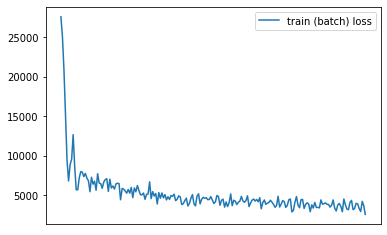

In [ ]:
''' In this cell we train the network '''
batch_loss = [] # list to track loss history
epochs = 50 # number of epochs

for epoch in tqdm(range(epochs), 'Training', position=0, leave=True):
    epoch_desc = f'epoch {epoch+1} / {epochs}' # string description of the epoch

    # process each training batch
    for (X, y) in train_dataloader:
        # trasfer batch to working device
        X = X.to(device)
        y = y.to(device)
        # run forward and backward passes on the batch
        optimizer.zero_grad()
        model.train()
        y_model = model(X)
        loss = MSE_loss(y_model, y)
        loss.backward()
        optimizer.step()
        # record performance on current batch
        batch_loss.append(loss.item())

# plot the batch loss history for the training process
plt.plot(batch_loss, label='train (batch) loss')
plt.xticks([])
plt.legend()
plt.show()
  

##Part G: Evaluating Our Model On a Separated Test Set

In [ ]:
with torch.no_grad():
    # load test data (that we separated from the train data in advance previously)
    X, y = next(iter(test_dataloader))
    X = X.to(device)
    y = y.to(device)

    # evaluate model on test data 
    model.eval()
    y_model = model(X)
    loss = MSE_loss(y_model, y)

    print(f'MSE loss on test data = {loss}')
    print(f'sqrt(loss) = {torch.sqrt(loss)}')

MSE loss on test data = 3187.6552734375
sqrt(loss) = 56.45932388305664


GL ^_^